#### Dataset vailable at: https://www.kaggle.com/dadhaniyatejas/covid19-xray

In [59]:
# Import necessary library
import tensorflow as tf
from keras.callbacks import EarlyStopping 
import os
from keras.layers import Dense, Input, Flatten, Lambda
from keras.models import Model
from keras.models import Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [42]:
# define image size.
# VGG16 accept image size as 224*224.

image_size = [224,224]

# training and validation data path
train_path = os.path.join('Dataset','train')
valid_path = os.path.join('Dataset','valid')

In [43]:
# create VGG16 object.
# include_top = False exclude the 3 fully-connected layers at the top of the network.

vgg = VGG16(input_shape= image_size + [3] ,
            weights = 'imagenet' ,
            include_top = False
           )

In [44]:
# freeze the pretrained weights to make training process faster.
# use pretrained weights.

for layer in vgg.layers:
    layer.trainable = False

In [45]:
# listing number of unique classe.
folder = glob(os.path.join('Dataset','train','*'))

In [47]:
# connect vgg output to flatten layers.
x = Flatten()(vgg.output)

In [48]:
# create output layer with softmax activation function.
output = Dense(len(folder), activation='softmax')(x)

# define input and output for model.
model = Model(inputs=vgg.input, outputs=output)

In [49]:
# visualize model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [50]:
# compile model with adam optimizer and categorical_crossentropy loss.

model.compile(optimizer='adam', 
              loss = "categorical_crossentropy", 
              metrics = ['accuracy']
             )

In [51]:
# generate more date sothat model train well

train_datagen = ImageDataGenerator(rescale= 1./255,
                                   shear_range= 0.2, 
                                   zoom_range= 0.2, 
                                   horizontal_flip= True
                                    )

valid_datagen = ImageDataGenerator(rescale= 1./255)

In [52]:
training_set = train_datagen.flow_from_directory(os.path.join('Dataset','train'), 
                                                 target_size=(224,224), 
                                                 batch_size= 32, 
                                                 class_mode= 'categorical'
                                                )

Found 251 images belonging to 3 classes.


In [53]:
validation_set = valid_datagen.flow_from_directory(os.path.join('Dataset','valid'), 
                                                 target_size=(224,224), 
                                                 batch_size= 32, 
                                                 class_mode= 'categorical'
                                                )

Found 63 images belonging to 3 classes.


In [60]:
# start training
# here we define earlystopping callback. if validation loss not decrese for consecutive 5 epoch the stop training. 
history = model.fit_generator(training_set,
                              validation_data=validation_set,
                              epochs=50,
                              steps_per_epoch = len(training_set),
                              validation_steps = len(validation_set),
                              callbacks= [EarlyStopping(monitor='val_loss',patience=5)]
                              )

Epoch 1/50
8/8 [==============================] - 77s 10s/step - loss: 0.9720 - accuracy: 0.6096 - val_loss: 0.6858 - val_accuracy: 0.6667
Epoch 2/50
8/8 [==============================] - 68s 8s/step - loss: 0.3530 - accuracy: 0.8486 - val_loss: 0.2749 - val_accuracy: 0.7302
Epoch 3/50
8/8 [==============================] - 74s 9s/step - loss: 0.2474 - accuracy: 0.8964 - val_loss: 0.1888 - val_accuracy: 0.9206
Epoch 4/50
8/8 [==============================] - 67s 8s/step - loss: 0.1688 - accuracy: 0.9402 - val_loss: 0.1787 - val_accuracy: 0.8571
Epoch 5/50
8/8 [==============================] - 58s 7s/step - loss: 0.0979 - accuracy: 0.9681 - val_loss: 0.1365 - val_accuracy: 0.9365
Epoch 6/50
8/8 [==============================] - 60s 7s/step - loss: 0.1168 - accuracy: 0.9562 - val_loss: 0.0921 - val_accuracy: 0.9524
Epoch 7/50
8/8 [==============================] - 58s 7s/step - loss: 0.0793 - accuracy: 0.9801 - val_loss: 0.0996 - val_accuracy: 0.9841
Epoch 8/50
8/8 [=================

In [62]:
import pandas as pd
record = pd.DataFrame(history.history)

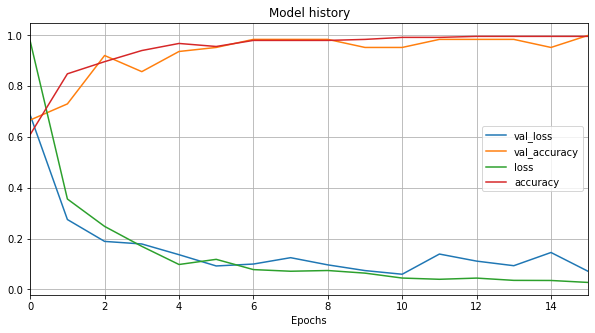

In [72]:
# plot model history.
record.plot(figsize=(10,5))
plt.grid()
plt.xlabel('Epochs')
plt.title('Model history')
plt.show()

In [74]:
# save the model.
from keras.models import load_model
model.save('VGG16.h5')

In [120]:
# class category
cls = ['Covid', 'Normal', 'Viral Pneumonia']

In [157]:
# coustom prediction
img = image.load_img(os.path.join('Dataset','test','viral (2).jpeg'),target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classs = model.predict(img_data)
cls[classs.argmax()]

'Viral Pneumonia'